In [1]:
%matplotlib notebook
import os
import numpy as np
import chaospy as cp
import pandas as pd
import seaborn as sns
import itertools
import scipy.stats as ss  
from numpy import linalg as LA
from matplotlib import pyplot as plt,cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel,WhiteKernel)

In [31]:
pltlinestyles = [ (0, (1, 5)),(0, (3, 5, 1, 5)),(0, (5, 5)),(0, ()), (0, (3, 1, 1, 1, 1, 1)), 
        (0, (5, 10)), (0, (3, 10, 1, 10)), (0, (3, 10, 1, 10, 1, 10)),(0, (1, 10)), 
        (0, (5, 1)),  (0, (3, 1, 1, 1)),(0, (3, 5, 1, 5, 1, 5)),  (0, (1, 1))  ]*10

pltmarkers   = ['o','v','s','d','+','*']
ordinal      = lambda n: "%d%s" % (n,"tsnrhtdd"[(math.floor(n/10)%10!=1)*(n%10<4)*n%10::4])
pltcolors    = plt.rcParams['axes.prop_cycle'].by_key()['color']
figsize      = (4*1.5,3*1.5)
pltlinewidth = 1.0
return_period= [1,5,10]
prob_fails   = [1/(p *365.25*24*3600/1000) for p in return_period]
pf1year, pf5year, pf10year = prob_fails
n_mcs = 1.0/np.array(prob_fails)*100
print('{:.0e}'.format(n_mcs[-1]))



3e+07


In [4]:
def make_circle(r,n=100):
    t = np.linspace(0, np.pi * 2.0, n)
    t = t.reshape((len(t), 1))
    x = r * np.cos(t)
    y = r * np.sin(t)
    return np.hstack((x, y))

In [3]:
MODEL_NAME      = 'linear_oscillator'
WORKING_DIR     = os.getcwd()
MODEL_DIR       = os.path.join('/Users/jinsongliu/BoxSync/MUSELab/museuq/examples', MODEL_NAME)
MODEL_DIR_FIGURE= os.path.join(MODEL_DIR,r'Figures')
MODEL_DIR_DATA  = os.path.join('/Users/jinsongliu/External/MUSE_UQ_DATA',MODEL_NAME,r'Data') 

print('WORKING_DIR: {}'.format(WORKING_DIR))
print('+-- MODEL: {}'.format(MODEL_DIR))
print('|   +-- {:<6s}: {}'.format('FIGURE',MODEL_DIR_FIGURE))
print('|   +-- {:<6s}: {}'.format('DATA',MODEL_DIR_DATA))


WORKING_DIR: /Users/jinsongliu/BoxSync/MUSELab/museuq/examples/JupyterNotebook
+-- MODEL: /Users/jinsongliu/BoxSync/MUSELab/museuq/examples/linear_oscillator
|   +-- FIGURE: /Users/jinsongliu/BoxSync/MUSELab/museuq/examples/linear_oscillator/Figures
|   +-- DATA  : /Users/jinsongliu/External/MUSE_UQ_DATA/linear_oscillator/Data


In [3]:
mu_Hs    = 0.77
sigma_Hs = 0.6565
Hs_shape = 1.503
Hs_scale = 2.691
h0       = 2.9
cdf_h0   = 0.6732524353557928
gamma    = 1.503
rho      = 2.691
zeta     = 0.6565

a1 = 1/(np.sqrt(2*np.pi)*0.6565*2.9) * np.exp(-(np.log(2.9)-0.77)**2/(2*0.6565**2))
a2 = (gamma/rho) * (2.9/rho)**(gamma-1) * np.exp(-(2.9/rho)**gamma)
print(a1)
print(a2)

0.18945993853083995
0.18941583365529419


In [49]:
# data_set = np.load(os.path.join(MODEL_DIR_DATA, 'DoE_QuadHem10_PCE_pred_E6R0.npy'))
# print(data_set.shape)
# data_set = np.load(os.path.join(MODEL_DIR_DATA, 'DoE_McRE6R6.npy'))
# print(data_set.shape)
# data_set = np.load(os.path.join(MODEL_DIR_DATA, 'DoE_McRE6R0_stats.npy'))
# print(data_set.shape)
# data_set = np.load(os.path.join(MODEL_DIR_DATA, 'DoE_QuadHem5R24_mPCE_pred_E6R9.npy'))
# print(data_set.shape)
# data_set = np.load(os.path.join(MODEL_DIR_DATA, 'DoE_QuadHem9R24_mPCE_pred_E6R6_y1_ecdf_P1.npy'))
# print(data_set.shape)
# data_set = np.load(os.path.join(MODEL_DIR_DATA, 'DoE_QuadHem9R24_mPCE_pred_E6R6_y1_ecdf_P5.npy'))
# print(data_set.shape)
# data_set = np.load(os.path.join(MODEL_DIR_DATA, 'DoE_QuadHem9R24_mPCE_pred_E6R6_y1_ecdf_P10.npy'))
# print(data_set.shape)
data_set = np.load(os.path.join(MODEL_DIR_DATA, 'linear_oscillator_run_DoE1_stats.npy'))
print(data_set.shape)
print(data_set[0])
data_set = np.load(os.path.join(MODEL_DIR_DATA, 'DoE_McR10R1_stats.npy'))
print(data_set.shape)
print(data_set[0])

(10, 6, 2)
[[-1.68307072e-04  7.59542954e-05]
 [ 1.28784313e-01  5.22094066e-01]
 [ 6.89327921e-03  2.04599275e-02]
 [ 1.26851792e-02 -7.69683876e-02]
 [ 4.21468749e-01  1.89589598e+00]
 [ 1.43981170e-05  3.18487514e-05]]
(10, 6, 2)
[[ 3.48785610e-05  5.98199370e-04]
 [ 1.27634225e-01  4.96447124e-01]
 [ 2.55757653e-03 -1.47089438e-02]
 [ 2.17795847e-01 -1.51114593e-01]
 [ 4.77135670e-01  1.47562176e+00]
 [ 2.51280365e-07  3.06856920e-05]]


(2, 2002)


<IPython.core.display.Javascript object>


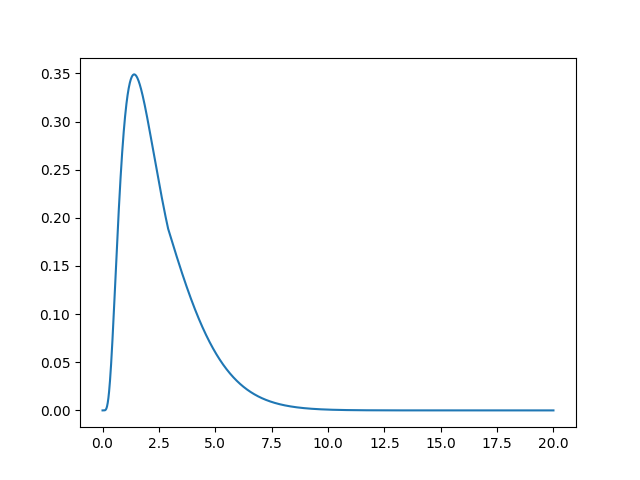

1.0017584199704654

In [5]:
data_set  = np.load('Kvitebjorn_hs.npy')
print(data_set.shape)
plt.figure()
plt.plot(data_set[0,:],data_set[1,:])
sum(data_set[1,:]*0.01)

<IPython.core.display.Javascript object>


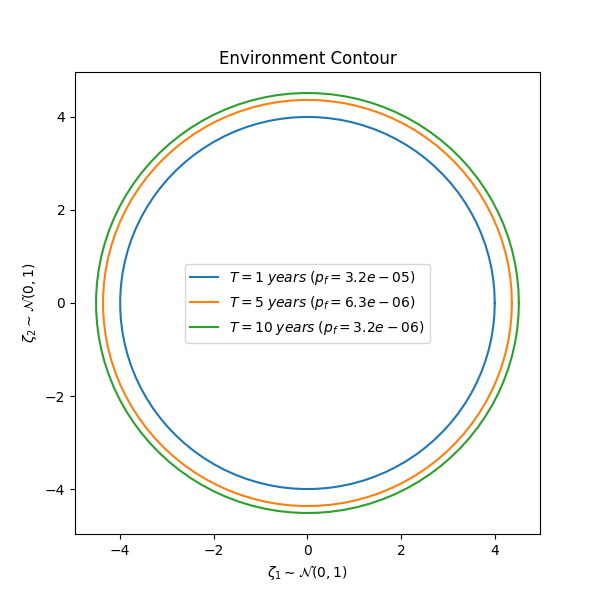

<IPython.core.display.Javascript object>


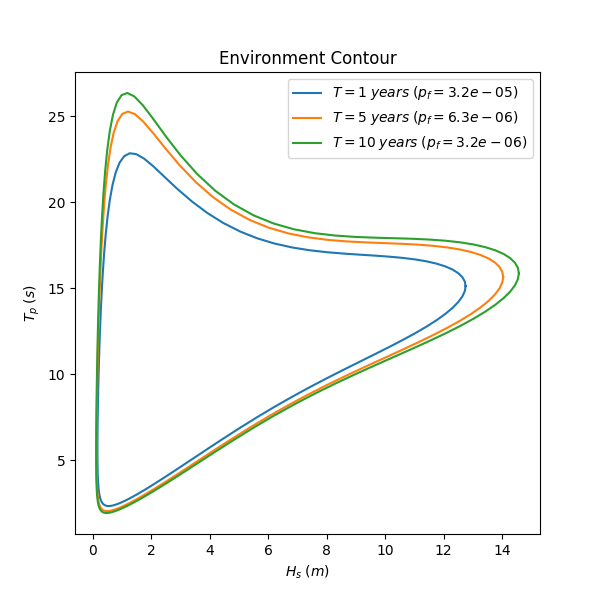

(4, 100)
(4, 100)
(4, 100)


In [16]:
fig_ec_z, axs_ec_z= plt.subplots(figsize=(4*1.5,4*1.5))
fig_ec_x, axs_ec_x= plt.subplots(figsize=(4*1.5,4*1.5))
for ipf, p in zip(prob_fails, return_period):
    data_set = np.load('Kvitebjorn_EC_P{:d}.npy'.format(p))
    print(data_set.shape)
    EC_zeta = data_set[:2,:]
    EC_x = data_set[2:,:]

    # beta = ss.norm.ppf(prob_fails)
    # print('{:<20s}:{:.4f}'.format('Reliability Index', beta))
    # EC_zeta = make_circle(beta,50)

    axs_ec_z.plot(EC_zeta[0,:],EC_zeta[1,:], label= r'$T = {:d} \;years \;(p_f = {:.1e})$'.format(p,ipf))
    axs_ec_z.set_xlabel('$\zeta_1\sim \mathcal{N}(0,1)$')
    axs_ec_z.set_ylabel('$\zeta_2\sim \mathcal{N}(0,1)$')
    axs_ec_z.set_title('Environment Contour');
    axs_ec_z.legend()

    axs_ec_x.plot(EC_x[0,:],EC_x[1,:], label= r'$T = {:d} \;years \;(p_f = {:.1e})$'.format(p,ipf))
    axs_ec_x.set_xlabel('$H_s \;(m)$')
    axs_ec_x.set_ylabel('$T_p \;(s)$')
    axs_ec_x.set_title('Environment Contour');
    axs_ec_x.legend()
    # axs_ec.set_aspect('equal', 'box')
    # axs_ec.set_aspect('equal', 'box')

    # print(EC_x.shape)
    # np.save(os.path.join(MODEL_DIR_DATA,'EC_pfe4'),EC_x)

#  Single Degree of Freedom Oscillator 
\begin{equation}
    m \ddot(x) + c \dot(x) + kx = f
\end{equation}
where,

$m = 100, c = 0.3, k = 2.25 \Rightarrow \omega_n = \sqrt{\frac{k}{m}} = 0.15Hz, \zeta = \frac{c}{2\sqrt{mk}} = 1\%$

$f$: External excitation force. Assuming Gaussian wave from JONSWAP($H_s, T_p$)

$(H_s, T_p) := \boldsymbol{X} \overset{i.i.d}{\sim} $

$(\zeta_1, \zeta_2) := \boldsymbol{\zeta} \overset{i.i.d}{\sim} \mathcal{N}(0,1)$


In [25]:
zeta    = 0.01
omega_n = 2 # rad/s
m       = 1 
k       = (omega_n/2/np.pi) **2 * m 
c       = zeta * 2 * np.sqrt(m * k)
mck     = (m,c,k)
print(m,c,k)

1 0.006366197723675814 0.10132118364233779


<IPython.core.display.Javascript object>


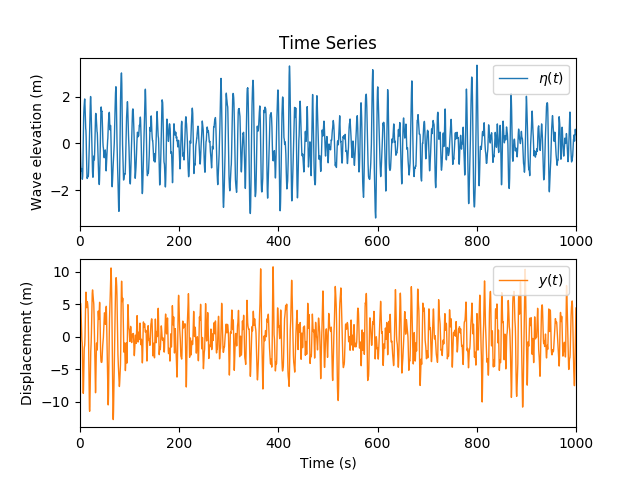

<IPython.core.display.Javascript object>


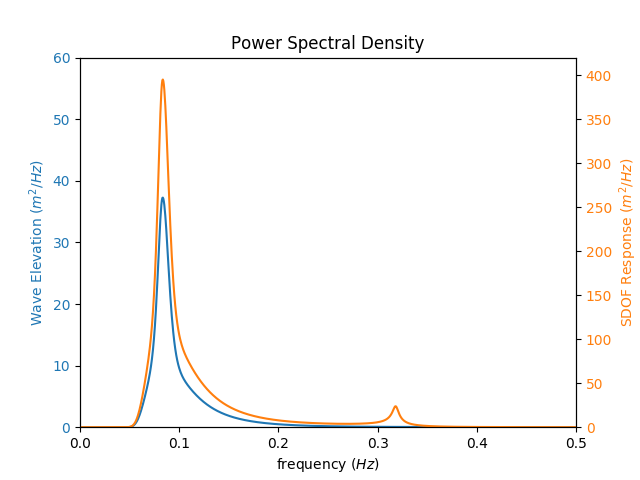

Text(0.5, 1.0, 'Power Spectral Density')

In [17]:
data_set  = np.load('test_linear_oscillator_y.npy')
sdof_time = data_set[:,:3]
sdof_freq = data_set[:,3:]
fig1, axs = plt.subplots(2,1)
axs[0].plot(sdof_time[:,0],sdof_time[:,1], label=r'$\eta(t)$',color=pltcolors[0],linewidth=pltlinewidth);
axs[1].plot(sdof_time[:,0],sdof_time[:,2], label=r'$y(t)$',color=pltcolors[1],linewidth=pltlinewidth);
axs[0].set_xlim(0,1000)
axs[0].set_ylabel('Wave elevation (m)')
axs[0].set_title('Time Series')
axs[0].legend(loc=1)

axs[1].set_xlim(0,1000)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Displacement (m)')
axs[1].legend(loc=1)


fig2, ax2 = plt.subplots()
ax2.plot(sdof_freq[:,0],sdof_freq[:,1],color=pltcolors[0]);
ax2.set_ylabel('Wave Elevation $(m^2/Hz)$',color=pltcolors[0])
ax2.tick_params(axis='y', labelcolor=pltcolors[0])
ax2.set_ylim(0,60)

ax3 = ax2.twinx()  # instantiate a second axes that shares the same x-axis
ax3.plot(sdof_freq[:,0],sdof_freq[:,2],color=pltcolors[1]);
ax3.set_ylabel('SDOF Response $(m^2/Hz)$',color=pltcolors[1])  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor=pltcolors[1])
ax3.set_ylim(0,420)
# ax2.tick_params(axis='y', labelcolor=color)


ax2.set_xlim(0,0.5)
ax2.set_xlabel(r'frequency ($Hz$)')
ax2.set_title('Power Spectral Density')
# ax2.legend(['JONSWAP($H_s={},T_p={}$)'.format(4, 12), 'PSD($y(t)$)'])

# 1. Design of Experiment

<IPython.core.display.Javascript object>


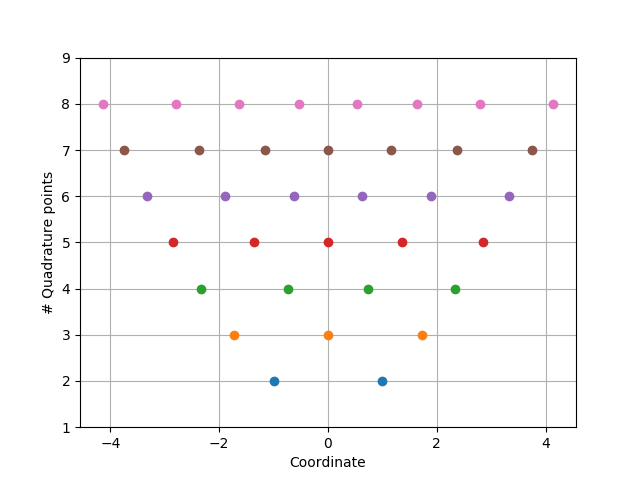

In [26]:
plt.figure()
for iorder in range(2,9):
    coord1d_e, weight1d_e = np.polynomial.hermite_e.hermegauss(iorder)
    plt.plot(coord1d_e, iorder/10*np.ones(coord1d_e.shape),'o');
locs, labels = plt.yticks()            # Get locations and labels
plt.yticks(locs, [str(int(i*10)) for i in locs]);
plt.grid()
plt.xlabel('Coordinate')
plt.ylabel('# Quadrature points')
plt.savefig('Quadrature_points.png')


In [22]:
ec_top_eta = []
ec_top_y   = []
for P in [1,5,10]:
    ec_in_filename = '/Users/jinsongliu/BoxSync/MUSELab/museuq/museuq/environment/Kvitebjorn_EC_P{:d}.npy'.format(P)
    data_set= np.load(ec_in_filename)
    ec_x    = data_set[2:,:]
    print(ec_x.shape)
    ec_out_filename = 'Kvitebjorn_EC2D_P{:d}_N25_y.npy'.format(P)
    ec_data = np.squeeze(np.load(os.path.join(MODEL_DIR_DATA, ec_out_filename)))
    print(ec_data.shape)
    ec_eta  = np.squeeze(ec_data[:,:,4,0])  # 4: absmax, 0: eta
    ec_y    = np.squeeze(ec_data[:,:,4,1])  # 4: absmax, 1: y
    ec_eta_median = np.median(ec_eta,axis=0)
    ec_y_median   = np.median(ec_y,axis=0)
    
    sorted_idx = np.argsort(-ec_eta_median) # descending
    print(sorted_idx.shape)
    ec_top_eta.append(np.vstack((ec_x[:,sorted_idx], ec_eta_median[sorted_idx])))
    sorted_idx = np.argsort(-ec_y_median)
    ec_top_y.append(np.vstack((ec_x[:,sorted_idx], ec_y_median[sorted_idx])))
print(np.array(ec_top_eta).shape)
# print(ec_top_y)

(2, 100)
(25, 100, 6, 2)
(100,)
(2, 100)
(25, 100, 6, 2)
(100,)
(2, 100)
(25, 100, 6, 2)
(100,)
(3, 3, 100)


In [24]:
hs = np.hstack((np.linspace(0,8,20)[1:],np.linspace(8,15,100)[1:]))
tp = np.hstack((np.linspace(0,15,100)[1:],np.linspace(15,30,20)[1:]))

res = []
for i in hs:
    for j in tp:
        res.append([i,j])
        
res = np.array(res).T
print(res.shape)
np.save('HsTp_grid',res)

data_set = np.load(os.path.join(MODEL_DIR_DATA, 'HsTp_grid118.npy'))
x = data_set[0,:].reshape(len(hs),len(hs))
y = data_set[1,:].reshape(len(hs),len(hs))
data_set = np.load(os.path.join(MODEL_DIR_DATA, 'HsTp_grid118_out.npy'))
data_set = np.squeeze(data_set[:,:,4,:])
print(data_set.shape)
data_set_mean = np.squeeze(np.mean(data_set, axis=0))
print(data_set_mean.shape)
z0 = data_set_mean[:,0].reshape(len(hs),len(hs))
z1 = data_set_mean[:,1].reshape(len(hs),len(hs))
fig = plt.figure(figsize=figsize)  
ax  = fig.gca(projection='3d')
surf = ax.plot_surface(x,y,z1,color='k',linewidth=0, alpha=0.5)

for idoe in np.arange(8,9):
    filename = 'DoE_QuadHem{:d}R0.npy'.format(idoe)
    data_set = np.load(os.path.join(MODEL_DIR_DATA,filename))
    train_x  = data_set[3,:]
    train_y  = data_set[4,:]
    data_set = np.load(os.path.join(MODEL_DIR_DATA, 'DoE_QuadHem{:d}_stats.npy'.format(idoe)))
    train_z  = np.squeeze(data_set[:, 4, 2])

    
    filename = 'DoE_QuadHem{:d}_GPR_grid.npy'.format(idoe)
    data_set = np.load(os.path.join(MODEL_DIR_DATA,filename))
    z        = data_set[:,1].reshape(len(hs),len(hs))
    ax.plot_surface(x,y,z,color='r',linewidth=0,alpha=0.5)
    ax.scatter(train_x,train_y,train_z)
    print(data_set.shape)
ax.set_xlabel('$H_s$')
ax.set_ylabel('$T_p$')
ax.set_zlabel('$y$')
# ax.view_init(elev=90, azim=90)
ax.set_xlim(2,12)
ax.set_zlim(5,25)
ax.set_zlim(0,40)

(2, 13924)
(30, 13924, 2)
(13924, 2)


<IPython.core.display.Javascript object>

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jinsongliu/External/MUSE_UQ_DATA/linear_oscillator/Data/DoE_QuadHem8_stats.npy'

In [25]:
for idoe in np.arange(5,11):
    filename = 'DoE_QuadHem{:d}.npy'.format(idoe)
    data_set = np.load(os.path.join(MODEL_DIR_DATA,filename))
    print('Data set shape: {}'.format(data_set.shape))
    train_zeta= data_set[:2,:]
    train_w  = data_set[2,:]
    train_x  = data_set[3:5,:]
    print('{:<15s}'.format('Train data shape'))
    print('{:<10s}: {}'.format('Train X', train_x.shape))
#     print('{:<10s}: \n{}'.format('Train X', np.around(train_x.T,2)))    
#     print('{:<10s}: \n{}'.format('Train zeta', np.around(train_zeta.T,2)))
    # print('{:<15s}: {}'.format('Y', train_y.shape))
    print('{:<10s}: {}'.format('Weight', train_w.shape))

    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(train_zeta[0,:],train_zeta[1,:],'o',label='Quadrature points: {:d}'.format(idoe));
    for iT, T in enumerate([1,5,10]):
        data_set = np.load('/Users/jinsongliu/BoxSync/MUSELab/museuq/museuq/environment/Kvitebjørn_EC_P{:d}.npy'.format(T))
        EC  = data_set[:2,:]
        ax.plot(EC[0,:],EC[1,:],'-.',color='gray', label=r'$EC:$ {:d} years'.format(T))
#         iec_top_eta = ec_top_eta[iT]
#         x = np.squeeze(iec_top_eta[0,:10])
#         y = np.squeeze(iec_top_eta[1,:10])
#         z = np.squeeze(iec_top_eta[2,:10])
#         ax.scatter(x,y, c=z)
    ax.set_xlabel(r'$\zeta_1$')
    ax.set_ylabel(r'$\zeta_2$')
    ax.set_title('Experimental Design ($\zeta$-space)')
#     circle = plt.Circle((0, 0), beta, color='b',alpha=0.4)
#     ax.add_artist(p)
#     ax.add_artist(circle)
#     ax.set_xlim(-4.5,4.5)
#     ax.set_ylim(-4.5,4.5)
    ax.set_aspect('equal', 'box')
    ax.legend(loc='upper right')
    plt.savefig(os.path.join(MODEL_DIR_FIGURE,'DoE_QuadHem{:d}_zeta.pdf'.format(idoe)))
    
 
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(train_x[0,:],train_x[1,:],'o',label='Quadrature points: {:d}'.format(idoe));
    for iT, T in enumerate([1,5,10]):
        data_set = np.load('/Users/jinsongliu/BoxSync/MUSELab/museuq/museuq/environment/Kvitebjørn_EC_P{:d}.npy'.format(T))
        EC  = data_set[2:,:]
        ax.plot(EC[0,:],EC[1,:],'-.',color='gray', label=r'$EC:$ {:d} years'.format(T))
        iec_top_y = ec_top_y[iT]
        x = np.squeeze(iec_top_y[0,:20])
        y = np.squeeze(iec_top_y[1,:20])
        z = np.squeeze(iec_top_y[2,:20])
        ax.scatter(x,y, c=z,s=10,cmap='coolwarm')
        if iT==1:
            ax.scatter(x[0],y[0],s=50,marker='x',c='r',label=r'Design point')
        else:
            ax.scatter(x[0],y[0],s=50,marker='x',c='r')
    ax.set_xlabel(r'$H_s$')
    ax.set_ylabel(r'$T_p$')
    ax.set_title('Experimental Design (physical space)')
#     circle = plt.Circle((0, 0), beta, color='b',alpha=0.4)
#     ax.add_artist(p)
#     ax.add_artist(circle)
#     ax.set_xlim(-4.5,4.5)
#     ax.set_ylim(-4.5,4.5)
#     ax.set_aspect('equal', 'box')
    ax.legend(loc='upper right')
    plt.savefig(os.path.join(MODEL_DIR_FIGURE,'DoE_QuadHem{:d}_env.pdf'.format(idoe)))
    
#     fig1, ax1 = plt.subplots(figsize=(6,6))
#     ax1.plot(train_x[0,:],train_x[1,:],'o');
#     ax1.set_xlabel(r'$x_1$')
#     ax1.set_ylabel(r'$x_2$')
#     # ax1.grid()
#     ax1.set_title('Experimental Design')


FileNotFoundError: [Errno 2] No such file or directory: '/Users/jinsongliu/External/MUSE_UQ_DATA/linear_oscillator/Data/DoE_QuadHem5.npy'

# 2. Run DoE (get train data) 

<IPython.core.display.Javascript object>


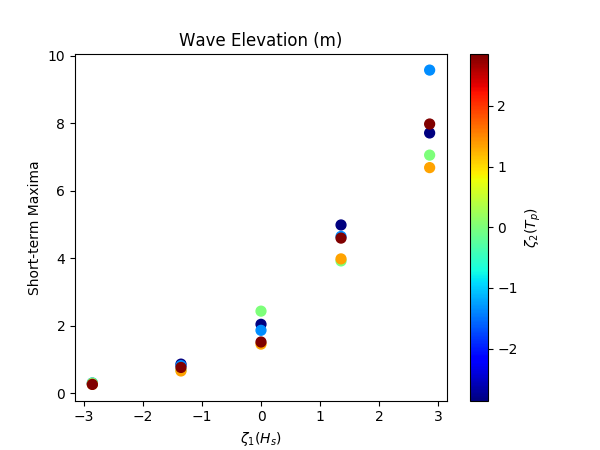

<IPython.core.display.Javascript object>


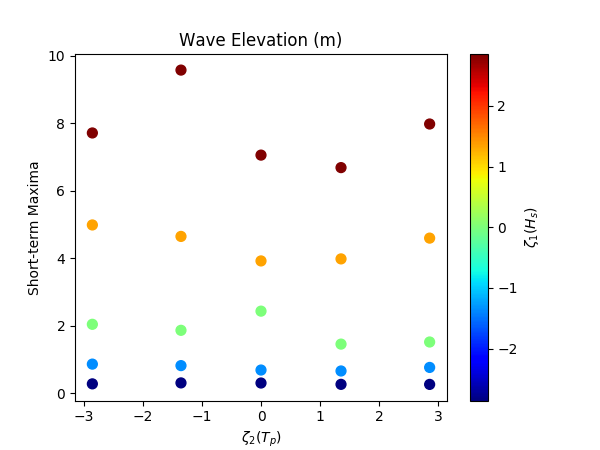

<IPython.core.display.Javascript object>


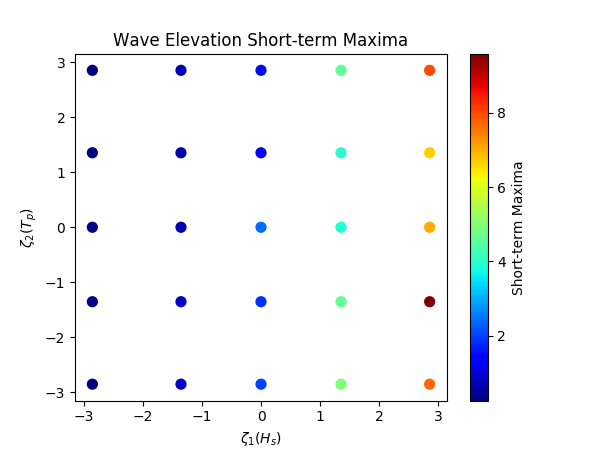

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


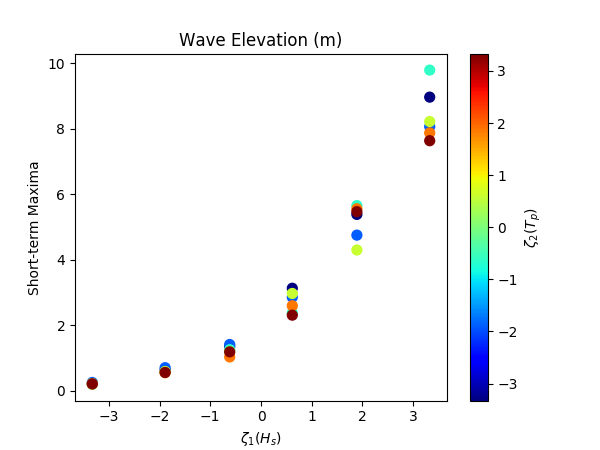

<IPython.core.display.Javascript object>


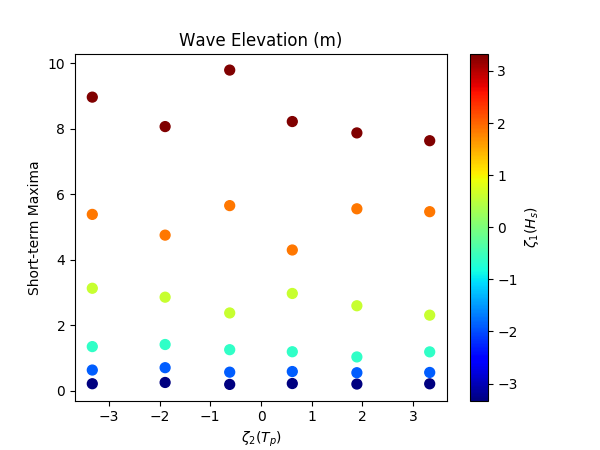

<IPython.core.display.Javascript object>


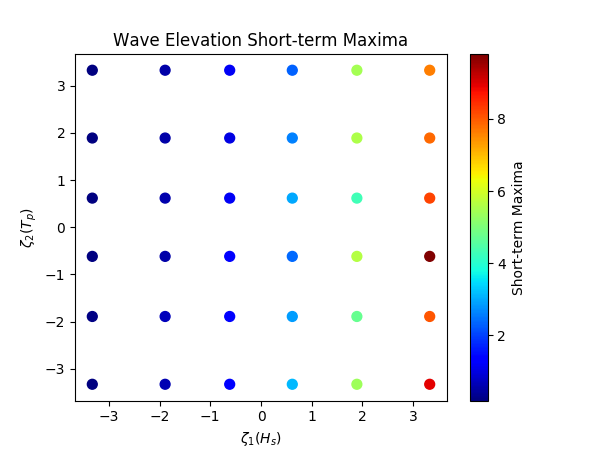

<IPython.core.display.Javascript object>


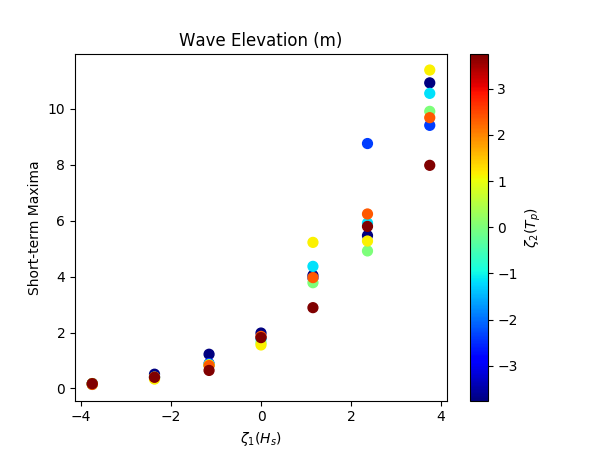

<IPython.core.display.Javascript object>


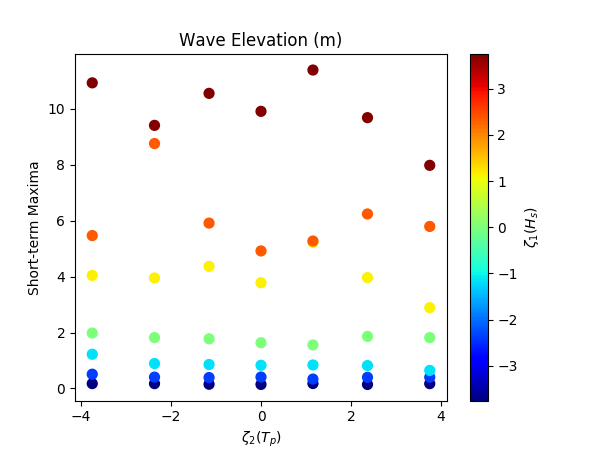

<IPython.core.display.Javascript object>


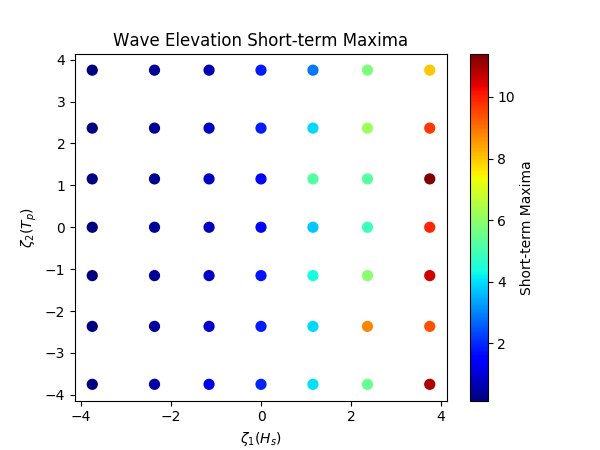

<IPython.core.display.Javascript object>


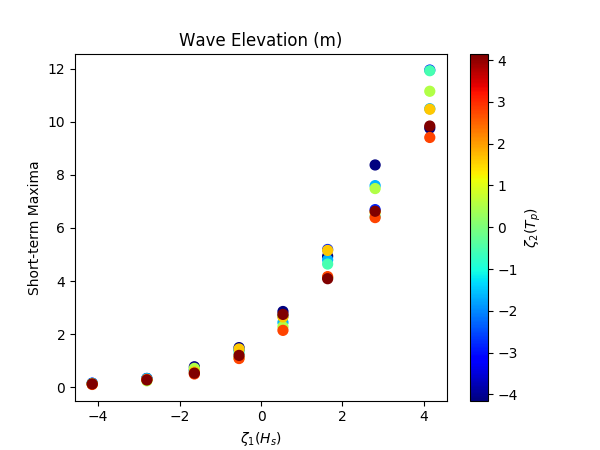

<IPython.core.display.Javascript object>


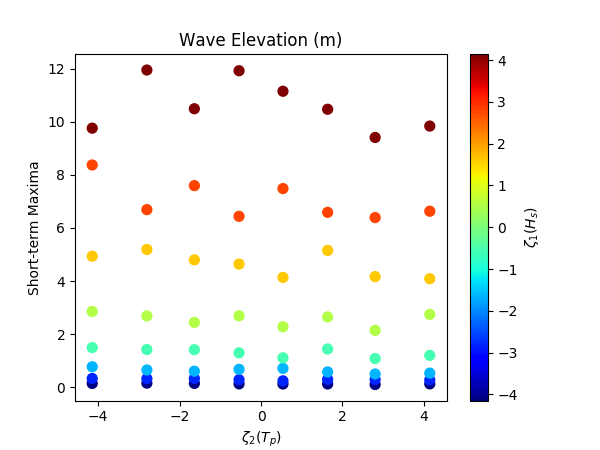

<IPython.core.display.Javascript object>


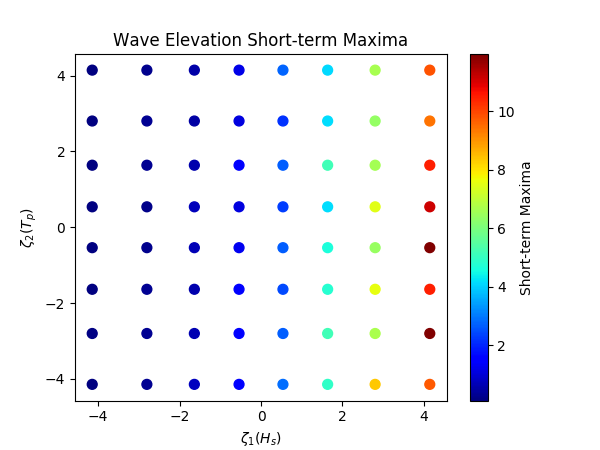

In [36]:
stats2analysis = 4  ##  [mean, std, skewness, kurtosis, absmax, absmin, up_crossing]
qoi2analysis   = 1  ## (t,eta,y,f,eta_pxx, y_pxx)
    
for idoe in np.arange(5,9):
    filename  = 'DoE_QuadHem{:d}.npy'.format(idoe)
    data_set  = np.load(os.path.join(MODEL_DIR_DATA,filename))
    train_zeta= data_set[:2,:]
    train_w   = data_set[2,:]
    train_x   = data_set[3:5,:]
    
    filename  = 'DoE_QuadHem{:d}_stats.npy'.format(idoe)
    data_set  = np.load(os.path.join(MODEL_DIR_DATA,filename))
    train_y   = np.squeeze(data_set[:, stats2analysis, qoi2analysis])
    
    fig       = plt.figure(figsize=figsize)    
    plt.scatter(train_zeta[0,:], train_y, c=train_zeta[1,:],s=50,cmap=cm.jet)
    plt.xlabel(r'$\zeta_1(H_s)$')
    plt.ylabel(r'Short-term Maxima')
    plt.title(r'Wave Elevation (m)')
    corbar = plt.colorbar()    
    corbar.set_label(r'$\zeta_2(T_p)$')
    plt.savefig(os.path.join(MODEL_DIR_FIGURE,'DoE_QuadHem{:d}_Xvs1.pdf'.format(idoe)))

    
    fig = plt.figure(figsize=figsize)    
    plt.scatter(train_zeta[1,:], train_y, c=train_zeta[0,:], s=50,cmap=cm.jet)
    plt.xlabel(r'$\zeta_2(T_p)$')
    plt.ylabel(r'Short-term Maxima')
    plt.title(r'Wave Elevation (m)')
    corbar = plt.colorbar()    
    corbar.set_label(r'$\zeta_1(H_s)$') 
    plt.savefig(os.path.join(MODEL_DIR_FIGURE,'DoE_QuadHem{:d}_Xvs2.pdf'.format(idoe)))
    
    fig = plt.figure(figsize=figsize)    
    plt.scatter(train_zeta[0,:], train_zeta[1,:], c=train_y, s=50,cmap=cm.jet)
    plt.xlabel(r'$\zeta_1(H_s)$')
    plt.ylabel(r'$\zeta_2(T_p)$')
    plt.title(r'Wave Elevation Short-term Maxima')
    corbar = plt.colorbar()    
    corbar.set_label(r'Short-term Maxima')
    plt.savefig(os.path.join(MODEL_DIR_FIGURE,'DoE_QuadHem{:d}_Xvs12.pdf'.format(idoe)))



<IPython.core.display.Javascript object>


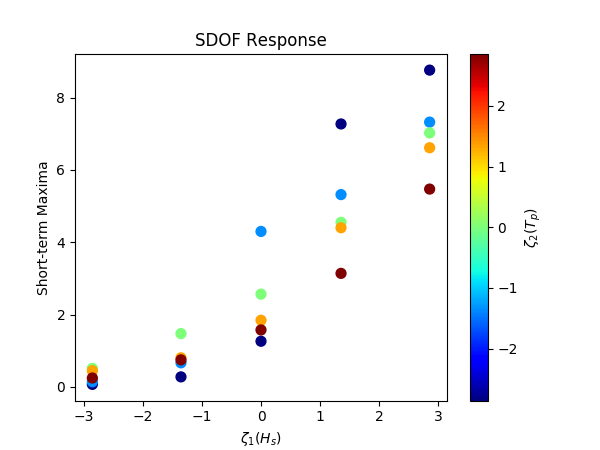

<IPython.core.display.Javascript object>


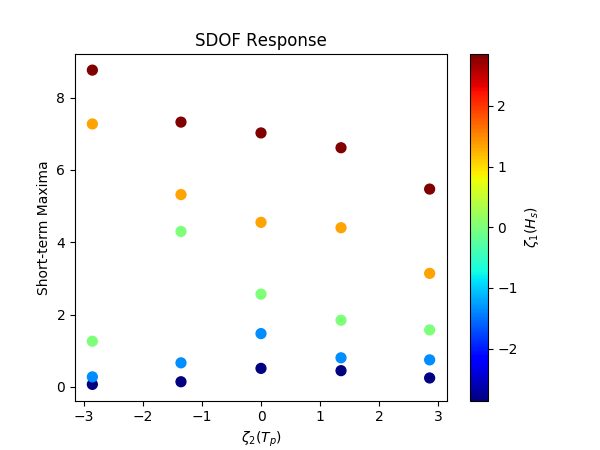

<IPython.core.display.Javascript object>


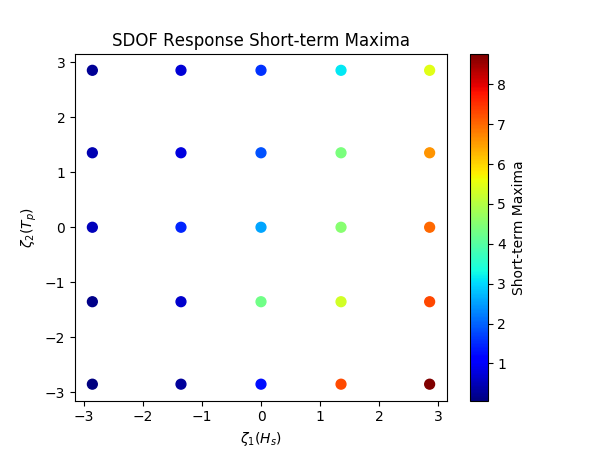

<IPython.core.display.Javascript object>


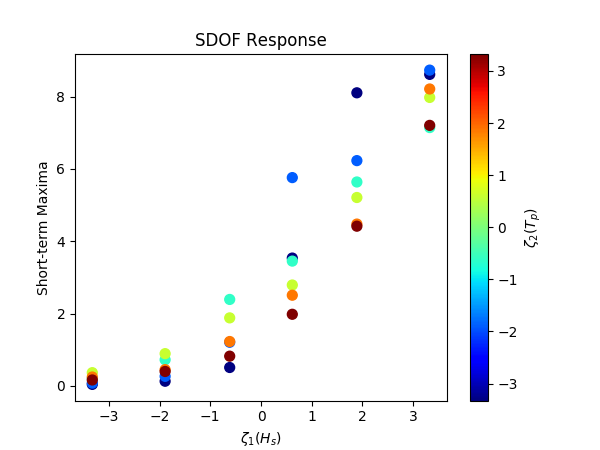

<IPython.core.display.Javascript object>


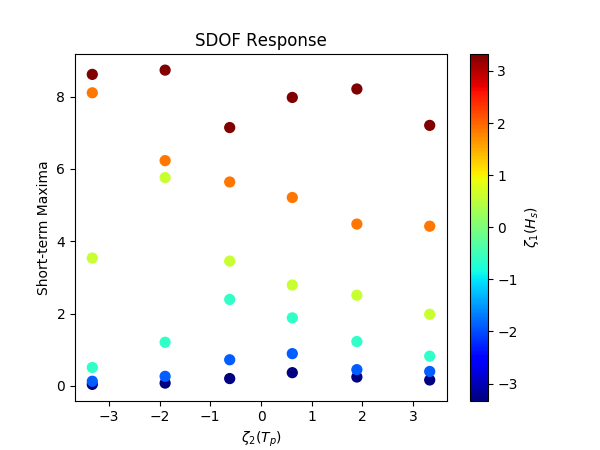

<IPython.core.display.Javascript object>


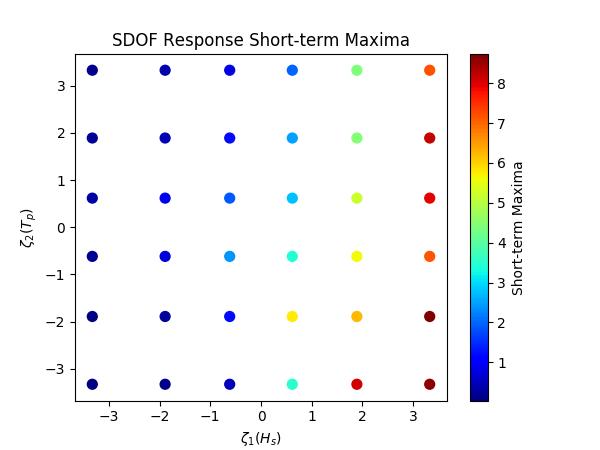

<IPython.core.display.Javascript object>


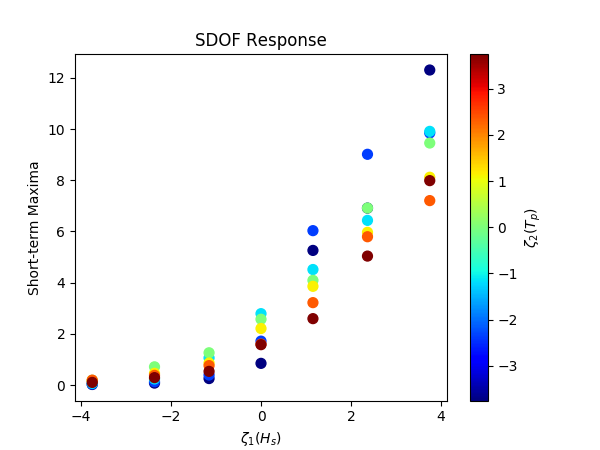

<IPython.core.display.Javascript object>


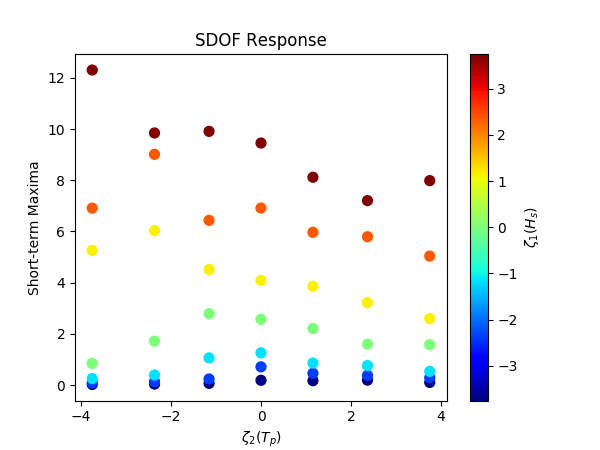

<IPython.core.display.Javascript object>


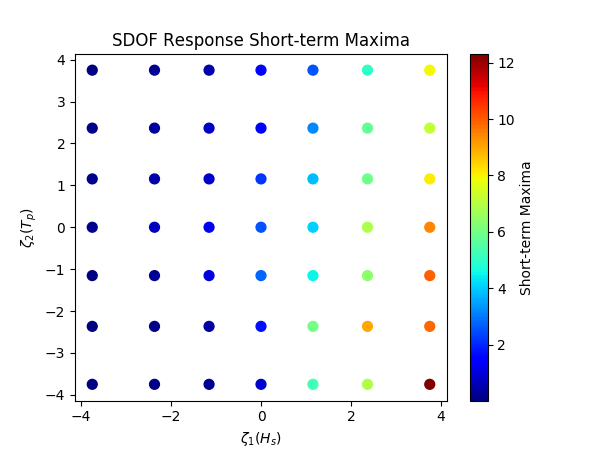

<IPython.core.display.Javascript object>


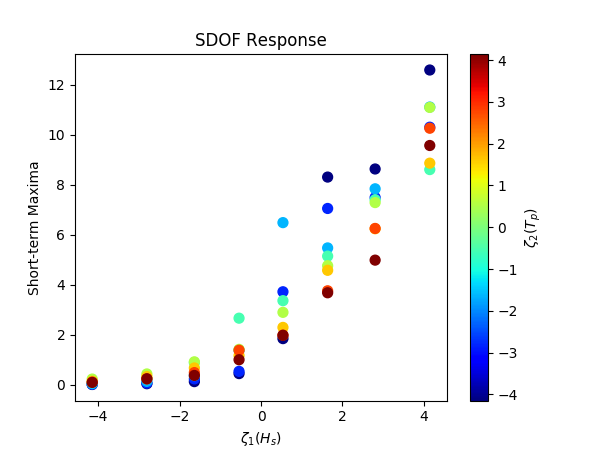

<IPython.core.display.Javascript object>


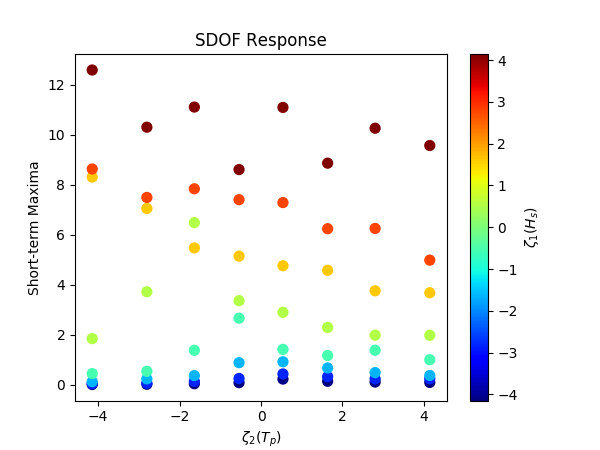

<IPython.core.display.Javascript object>


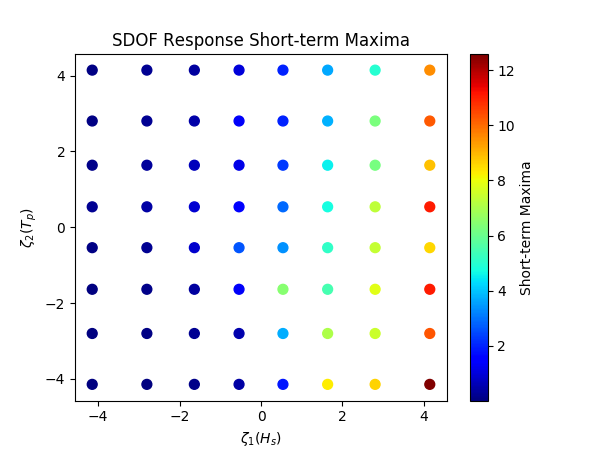

In [37]:
stats2analysis = 4 ##  [mean, std, skewness, kurtosis, absmax, absmin, up_crossing]
qoi2analysis   = 2 ## (t,eta,y,f,eta_pxx, y_pxx)
    
for idoe in np.arange(5,9):
    filename  = 'DoE_QuadHem{:d}.npy'.format(idoe)
    data_set  = np.load(os.path.join(MODEL_DIR_DATA,filename))
    train_zeta= data_set[:2,:]
    train_w   = data_set[2,:]
    train_x   = data_set[3:5,:]
    
    filename  = 'DoE_QuadHem{:d}_stats.npy'.format(idoe)
    data_set  = np.load(os.path.join(MODEL_DIR_DATA,filename))
    train_y   = np.squeeze(data_set[:, stats2analysis, qoi2analysis])
    
    fig       = plt.figure(figsize=figsize)    
    plt.scatter(train_zeta[0,:], train_y, c=train_zeta[1,:],s=50,cmap=cm.jet)
    plt.xlabel(r'$\zeta_1(H_s)$')
    plt.ylabel(r'Short-term Maxima')
    plt.title(r'SDOF Response')
    corbar = plt.colorbar()    
    corbar.set_label(r'$\zeta_2(T_p)$')
    plt.savefig(os.path.join(MODEL_DIR_FIGURE,'DoE_QuadHem{:d}_Yvs1.pdf'.format(idoe)))

    
    fig = plt.figure(figsize=figsize)    
    plt.scatter(train_zeta[1,:], train_y, c=train_zeta[0,:], s=50,cmap=cm.jet)
    plt.xlabel(r'$\zeta_2(T_p)$')
    plt.ylabel(r'Short-term Maxima')
    plt.title(r'SDOF Response')
    corbar = plt.colorbar()    
    corbar.set_label(r'$\zeta_1(H_s)$') 
    plt.savefig(os.path.join(MODEL_DIR_FIGURE,'DoE_QuadHem{:d}_Yvs2.pdf'.format(idoe)))
    
    fig = plt.figure(figsize=figsize)    
    plt.scatter(train_zeta[0,:], train_zeta[1,:], c=train_y, s=50,cmap=cm.jet)
    plt.xlabel(r'$\zeta_1(H_s)$')
    plt.ylabel(r'$\zeta_2(T_p)$')
    plt.title(r'SDOF Response Short-term Maxima')
    corbar = plt.colorbar()    
    corbar.set_label(r'Short-term Maxima')
    plt.savefig(os.path.join(MODEL_DIR_FIGURE,'DoE_QuadHem{:d}_Yvs12.pdf'.format(idoe)))



train x shape: (2, 25)
train y shape: (25,)
train eta shape: (25,)
pred  eta shape: (2, 25)


<IPython.core.display.Javascript object>


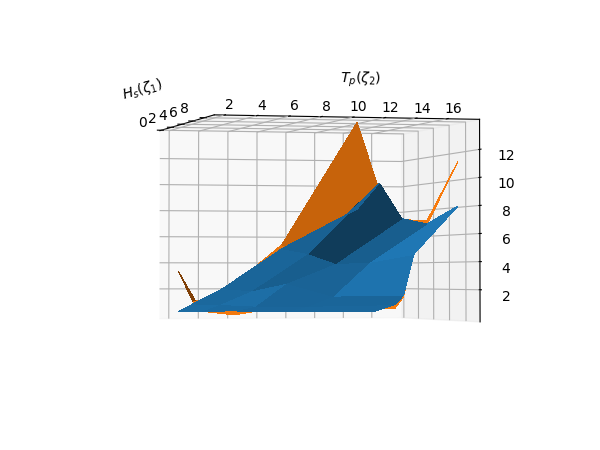

<IPython.core.display.Javascript object>


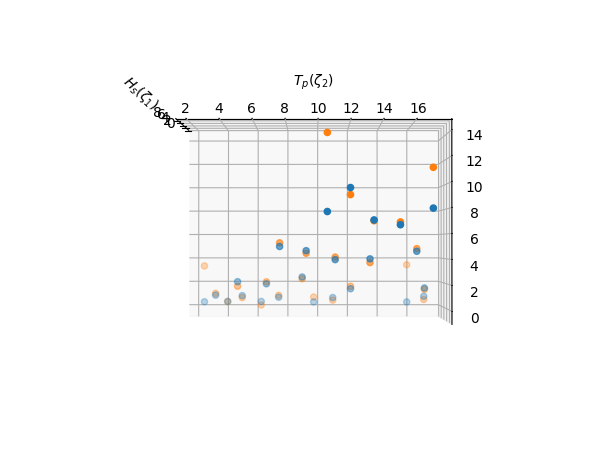

train x shape: (2, 36)
train y shape: (36,)
train eta shape: (36,)
pred  eta shape: (2, 36)


<IPython.core.display.Javascript object>


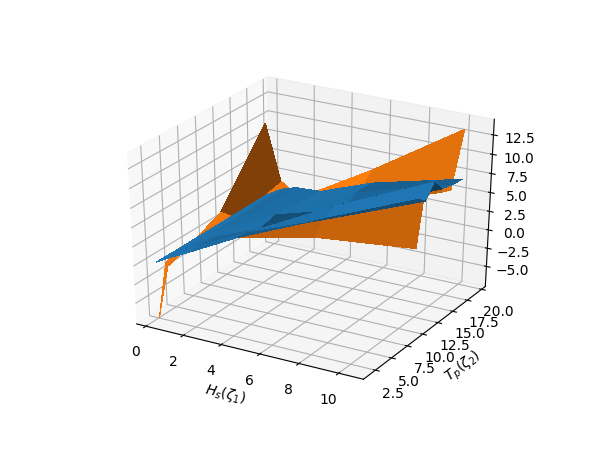

<IPython.core.display.Javascript object>


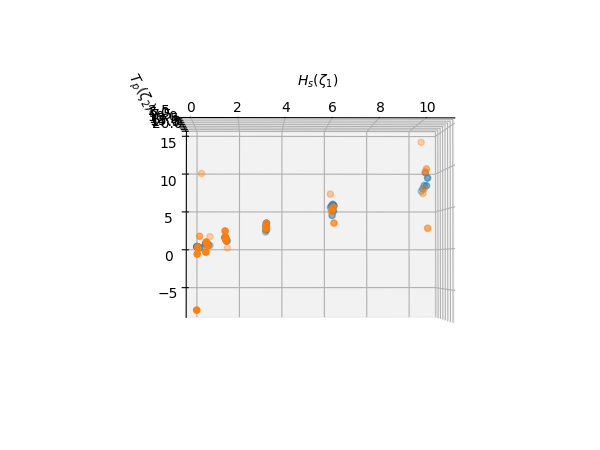

train x shape: (2, 49)
train y shape: (49,)
train eta shape: (49,)
pred  eta shape: (2, 49)


<IPython.core.display.Javascript object>


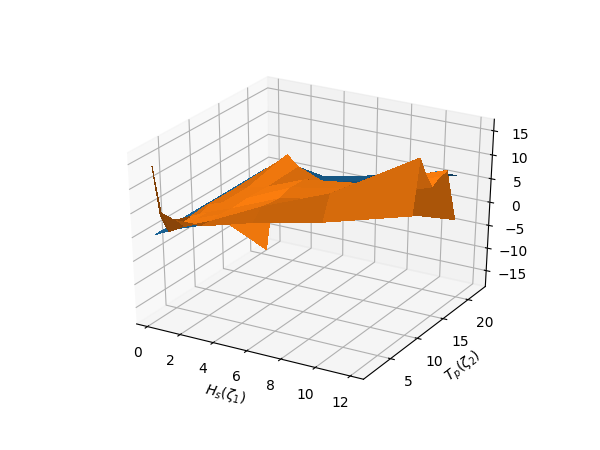

<IPython.core.display.Javascript object>


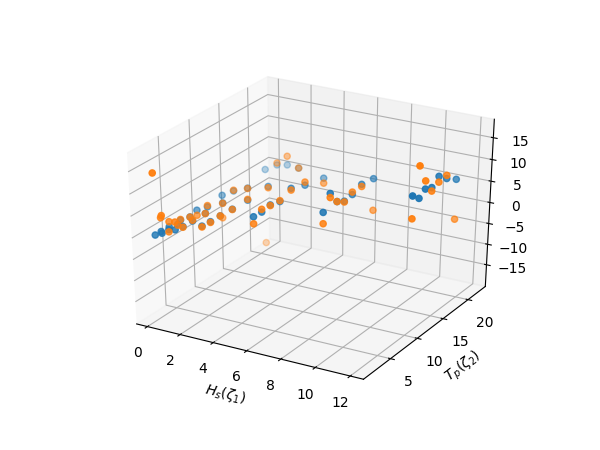

In [42]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm

for idoe in np.arange(5,8):
    filename  = 'DoE_QuadHem{:d}.npy'.format(idoe)
    data_set  = np.load(os.path.join(MODEL_DIR_DATA,filename))
    train_zeta= data_set[:2,:]
    train_w   = data_set[2,:]
    train_x   = data_set[3:5,:]
    
    filename  = 'DoE_QuadHem{:d}_stats.npy'.format(idoe)
    data_set  = np.load(os.path.join(MODEL_DIR_DATA,filename))
    train_eta = np.squeeze(data_set[:, 4, 1])#  [mean, std, skewness, kurtosis, absmax, absmin, up_crossing]
    train_y   = np.squeeze(data_set[:, 4, 2])
    filename  = 'DoE_QuadHem{:d}_valid.npy'.format(idoe)
    pred_eta  = np.load(os.path.join(MODEL_DIR_DATA,filename)).T
    print('train x shape: {}'.format(train_x.shape))
    print('train y shape: {}'.format(train_y.shape))
    print('train eta shape: {}'.format(train_eta.shape))
    print('pred  eta shape: {}'.format(pred_eta.shape))
#     print(train_zeta[0,:].reshape(5,5).T)
#     print(train_zeta[1,:].reshape(5,5).T)
    
#     fig = plt.figure(figsize=figsize)    
#     plt.scatter(train_zeta[0,:], train_y, c=train_zeta[1,:],s=50,cmap=cm.jet)
#     plt.xlabel(r'$\zeta_1(H_s)$')
#     plt.ylabel(r'Short-term Maxima')
#     plt.title(r'SDOF Response')
#     corbar = plt.colorbar()    
#     corbar.set_label(r'$\zeta_2(T_p)$')
#     plt.savefig(os.path.join(MODEL_DIR_FIGURE,'DoE_QuadHem{:d}_Yvs1.pdf'.format(idoe)))

#     fig = plt.figure(figsize=figsize)    
#     plt.scatter(train_zeta[1,:], train_y, c=train_zeta[0,:], s=50,cmap=cm.jet)
#     plt.xlabel(r'$\zeta_2(T_p)$')
#     plt.ylabel(r'Short-term Maxima')
#     plt.title(r'SDOF Response')
#     corbar = plt.colorbar()    
#     corbar.set_label(r'$\zeta_1(H_s)$') 
#     plt.savefig(os.path.join(MODEL_DIR_FIGURE,'DoE_QuadHem{:d}_Yvs2.pdf'.format(idoe)))
    
    fig = plt.figure(figsize=figsize)  
    ax  = fig.gca(projection='3d')
    x   = train_x[0,:].reshape(idoe,idoe).T
    y   = train_x[1,:].reshape(idoe,idoe).T
    z   = train_eta.reshape(idoe,idoe).T
    z0  = pred_eta[0,:].reshape(idoe,idoe).T
    surf = ax.plot_surface(x,y,z,linewidth=0, antialiased=False)
    surf = ax.plot_surface(x,y,z0,linewidth=0, antialiased=False)
    ax.set_xlabel(r'$H_s(\zeta_1)$')
    ax.set_ylabel(r'$T_p(\zeta_2)$')
    
    
    fig = plt.figure(figsize=figsize)  
    ax  = fig.gca(projection='3d')
    x   = train_x[0,:].reshape(idoe,idoe).T
    y   = train_x[1,:].reshape(idoe,idoe).T
    z   = train_eta.reshape(idoe,idoe).T
    z0  = pred_eta[0,:].reshape(idoe,idoe).T
    ax.scatter(train_x[0,:],train_x[1,:],train_eta)
    ax.scatter(train_x[0,:],train_x[1,:],pred_eta[0,:])
    ax.set_xlabel(r'$H_s(\zeta_1)$')
    ax.set_ylabel(r'$T_p(\zeta_2)$')
    
       
#     plt.scatter(train_x[0,:], train_x[1,:], c=train_y, s=50,cmap=cm.jet)
#     plt.xlabel(r'$\zeta_1(H_s)$')
#     plt.ylabel(r'$\zeta_2(T_p)$')
#     plt.title(r'SDOF Response Short-term Maxima')
#     corbar = plt.colorbar()    
#     corbar.set_label(r'Short-term Maxima')
#     plt.savefig(os.path.join(MODEL_DIR_FIGURE,'DoE_QuadHem{:d}_Yvs12.pdf'.format(idoe)))



## Exceedance plots

In [ ]:
print(MODEL_DIR_DATA)
pf  = 1e-5
for quad_order in range(5,10):
#     label_added = False
    fig2        = plt.figure(figsize=figsize)
    ax2         = fig2.add_subplot(1,1,1)
    nmcs_repeat           = range(10)
    mcs_exceedance_values = [] 
    pce_exceedance_values = [] 
    gpr_exceedance_values = [] 
    for imcs_repeat in nmcs_repeat:

        mcs_ecdf_filename = 'DoE_McRE6R{:d}_eta_ecdf_pf5.npy'.format(imcs_repeat)
        mcs_ecdf = np.load(os.path.join(MODEL_DIR_DATA, mcs_ecdf_filename)) 
        mpce_mcs_ecdf_filename = 'DoE_QuadHem{:d}_mPCE_pred_r{:d}_ecdf_pf5_eta.npy'.format(quad_order,imcs_repeat)
        print(mpce_mcs_ecdf_filename)
        mpce_mcs_ecdf = np.load(os.path.join(MODEL_DIR_DATA, mpce_mcs_ecdf_filename))
#         pce_mcs_ecdf_mean = np.squeeze(np.mean(np.array(pce_mcs_ecdf), axis=0))
#         gpr_mcs_ecdf_filename = 'DoE_QuadHem{:d}_GPRx_pred_r{:d}_ecdf_pf5_eta.npy'.format(quad_order,imcs_repeat)
#         gpr_mcs_ecdf = np.load(os.path.join(MODEL_DIR_DATA, gpr_mcs_ecdf_filename)) 
        
#         if not label_added:
            # Ture model emperical exceedance plot with mcs results
        label=r'$MCS(10^6)$'
        ax2.semilogy(mcs_ecdf[0,:], 1-mcs_ecdf[1,:],'k',linewidth=1,label=label if imcs_repeat==1 else '')
        # PCE model emperical exceedance plot with mcs results 
        label = r'$multi-PCE: p={:>2d}$'.format(quad_order-1)
        ax2.semilogy(mpce_mcs_ecdf[0,:], 1-mpce_mcs_ecdf[1,:],'-.',color=pltcolors[1],linewidth=1,label=label if imcs_repeat==1 else '')

#             ax2.semilogy(gpr_mcs_ecdf[0,:], 1-gpr_mcs_ecdf[1,:],'-.',
#                          color=pltcolors[2],linewidth=1,label=r'$GPR(RBF+WN)$')
#         else:
#             ax2.semilogy(mcs_ecdf[0,:], 1-mcs_ecdf[1,:],'k')
            
# #             ax2.semilogy(pce_mcs_ecdf_mean[0,:], 1-pce_mcs_ecdf_mean[1,:],'-.',color=pltcolors[11],linewidth=1)  
#             ax2.semilogy(mpce_mcs_ecdf[0,:], 1-mpce_mcs_ecdf[1,:],'-.',color=pltcolors[1],linewidth=1)  
#             ax2.semilogy(gpr_mcs_ecdf[0,:], 1-gpr_mcs_ecdf[1,:],'-.',color=pltcolors[2],linewidth=1)  
            
#         mcs_exceedance_values.append(mcs_ecdf[2,0])
#         pce_exceedance_values.append(pce_mcs_ecdf[2,0])
#         gpr_exceedance_values.append(gpr_mcs_ecdf[2,0])
#         label_added =True

    ax2.set_xlim(0,25)
    ax2.set_ylim(pf/10,1)
    xmin, xmax = ax2.get_xlim()
    ymin, ymax = ax2.get_ylim()
    ax2.plot([xmin,xmax],[pf,pf],':r',linewidth=1)
    ax2.text(xmax,pf,r'pf={:.0e}'.format(pf),horizontalalignment='right',verticalalignment='bottom')    
#     line1 = 1/(1 *365.25*24*3600/1000)
#     line2 = 1/(5 *365.25*24*3600/1000)
#     line3 = 1/(10*365.25*24*3600/1000)
#     ax2.plot([xmin,xmax],[line1,line1],':k',linewidth=1)
#     ax2.text(xmax,line1*1.2,r'1-year',horizontalalignment='right')
#     ax2.plot([xmin,xmax],[line2,line2],':k',linewidth=1)
#     ax2.text(xmax,line2*1.2,r'5-year',horizontalalignment='right')
#     ax2.plot([xmin,xmax],[line3,line3],':k',linewidth=1)
#     ax2.text(xmax,line3*1.2,r'10-year',horizontalalignment='right')
#     ## EC results
#     ax2.plot([ec_extreme_eta[0],ec_extreme_eta[0]],[ymin,line1],'-.k',linewidth=1,label=r'EC')
# #     ax2.text(ec_extreme_eta[0]*0.8,line1*1.2,r'EC(1-year):{:.2f}'.format(ec_extreme_eta[0]),color='red')
    
#     ax2.plot([ec_extreme_eta[1],ec_extreme_eta[1]],[ymin,line2],'-.k',linewidth=1)
# #     ax2.text(ec_extreme_eta[1]*0.8,line2*1.2,r'EC(5-year):{:.2f}'.format(ec_extreme_eta[1]),color='red')
    
#     ax2.plot([ec_extreme_eta[2],ec_extreme_eta[2]],[ymin,line3],'-.k',linewidth=1)
# #     ax2.text(ec_extreme_eta[2]*0.8,line3*1.2,r'EC(10-year):{:.2f}'.format(ec_extreme_eta[2]),color='red')
    
    ax2.set_xlabel(r'$\eta$')
    ax2.set_ylabel(r'Exceedance probability $\mathcal{P}\;(x>\eta)$')
    ax2.set_title(r'Wave Elevation ($\eta$) Exceedance (No. samples: {:d})'.format(quad_order**2))
    plt.legend()
    plt.grid()
    # plt.show()
    plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'ExceedancePlot_mPCE_DoE_Quadrature{:d}_eta-0.pdf'.format(quad_order)))
    ax2.set_xlim(0,15)
    ax2.set_ylim(pf,1)
    plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'ExceedancePlot_mPCE_DoE_Quadrature{:d}_eta-1.pdf'.format(quad_order)))






/Users/jinsongliu/External/MUSE_UQ_DATA/linear_oscillator/Data


<IPython.core.display.Javascript object>


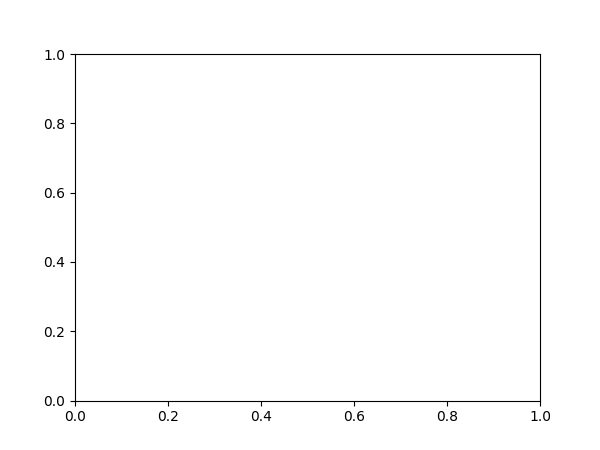

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jinsongliu/External/MUSE_UQ_DATA/linear_oscillator/Data/DoE_QuadHem5_pred_r0_ecdf_pf5_eta.npy'

In [26]:
print(MODEL_DIR_DATA)
pf  = 1e-5
for quad_order in range(5,11):
    label_added = False
    fig2        = plt.figure(figsize=figsize)
    ax2         = fig2.add_subplot(1,1,1)
    nmcs_repeat           = range(10)
    mcs_exceedance_values = [] 
    pce_exceedance_values = [] 
    gpr_exceedance_values = [] 
    for imcs_repeat in nmcs_repeat:

        mcs_ecdf_filename = 'DoE_McRE6R{:d}_eta_ecdf_pf5.npy'.format(imcs_repeat)
        mcs_ecdf = np.load(os.path.join(MODEL_DIR_DATA, mcs_ecdf_filename)) 
        
        pce_mcs_ecdf_filename = 'DoE_QuadHem{:d}_pred_r{:d}_ecdf_pf5_eta.npy'.format(quad_order,imcs_repeat)
        pce_mcs_ecdf = np.load(os.path.join(MODEL_DIR_DATA, pce_mcs_ecdf_filename))    

        gpr_mcs_ecdf_filename = 'DoE_QuadHem{:d}_GPRx_pred_r{:d}_ecdf_pf5_eta.npy'.format(quad_order,imcs_repeat)
        gpr_mcs_ecdf = np.load(os.path.join(MODEL_DIR_DATA, gpr_mcs_ecdf_filename)) 
        
        if not label_added:
            # Ture model emperical exceedance plot with mcs results
            ax2.semilogy(mcs_ecdf[0,:], 1-mcs_ecdf[1,:],'k',linewidth=1, label=r'$MCS(10^6)$')
            # PCE model emperical exceedance plot with mcs results  
            ax2.semilogy(pce_mcs_ecdf[0,:], 1-pce_mcs_ecdf[1,:],'-.',
                         color=pltcolors[1],linewidth=1,label=r'$PCE: p={:>2d}$'.format(quad_order-1))
            ax2.semilogy(gpr_mcs_ecdf[0,:], 1-gpr_mcs_ecdf[1,:],'-.',
                         color=pltcolors[2],linewidth=1,label=r'$GPR(RBF+WN)$')
        else:
            ax2.semilogy(mcs_ecdf[0,:], 1-mcs_ecdf[1,:],'k')
            ax2.semilogy(pce_mcs_ecdf[0,:], 1-pce_mcs_ecdf[1,:],'-.',color=pltcolors[1],linewidth=1)  
            ax2.semilogy(gpr_mcs_ecdf[0,:], 1-gpr_mcs_ecdf[1,:],'-.',color=pltcolors[2],linewidth=1)  
            
        mcs_exceedance_values.append(mcs_ecdf[2,0])
        pce_exceedance_values.append(pce_mcs_ecdf[2,0])
        gpr_exceedance_values.append(gpr_mcs_ecdf[2,0])
        label_added =True

    ax2.set_xlim(0,25)
    ax2.set_ylim(pf/10,1)
    xmin, xmax = ax2.get_xlim()
    ymin, ymax = ax2.get_ylim()
    line1 = 1/(1 *365.25*24*3600/1000)
    line2 = 1/(5 *365.25*24*3600/1000)
    line3 = 1/(10*365.25*24*3600/1000)
    ax2.plot([xmin,xmax],[line1,line1],':k',linewidth=1)
    ax2.text(xmax,line1*1.2,r'1-year',horizontalalignment='right')
    ax2.plot([xmin,xmax],[line2,line2],':k',linewidth=1)
    ax2.text(xmax,line2*1.2,r'5-year',horizontalalignment='right')
    ax2.plot([xmin,xmax],[line3,line3],':k',linewidth=1)
    ax2.text(xmax,line3*1.2,r'10-year',horizontalalignment='right')
    ## EC results
    ax2.plot([ec_extreme_eta[0],ec_extreme_eta[0]],[ymin,line1],'-.k',linewidth=1,label=r'EC')
#     ax2.text(ec_extreme_eta[0]*0.8,line1*1.2,r'EC(1-year):{:.2f}'.format(ec_extreme_eta[0]),color='red')
    
    ax2.plot([ec_extreme_eta[1],ec_extreme_eta[1]],[ymin,line2],'-.k',linewidth=1)
#     ax2.text(ec_extreme_eta[1]*0.8,line2*1.2,r'EC(5-year):{:.2f}'.format(ec_extreme_eta[1]),color='red')
    
    ax2.plot([ec_extreme_eta[2],ec_extreme_eta[2]],[ymin,line3],'-.k',linewidth=1)
#     ax2.text(ec_extreme_eta[2]*0.8,line3*1.2,r'EC(10-year):{:.2f}'.format(ec_extreme_eta[2]),color='red')
    
    ax2.set_xlabel(r'$\eta$')
    ax2.set_ylabel(r'Exceedance probability $\mathcal{P}\;(x>\eta)$')
    ax2.set_title(r'Wave Elevation ($\eta$) Exceedance (No. samples: {:d})'.format(quad_order**2))
    plt.legend()
    plt.grid()
    # plt.show()
    plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'ExceedancePlot_PCEGPR_DoE_Quadrature{:d}_eta.pdf'.format(quad_order)))


    label_added =False
    fig2 = plt.figure(figsize=figsize)
    ax2 = fig2.add_subplot(1,1,1)
    nmcs_repeat           = range(7)
    mcs_exceedance_values = [] 
    pce_exceedance_values = [] 
    gpr_exceedance_values = [] 
    for imcs_repeat in nmcs_repeat:

        mcs_ecdf_filename = 'DoE_McRE6R{:d}_y_ecdf_pf5.npy'.format(imcs_repeat)
        mcs_ecdf = np.load(os.path.join(MODEL_DIR_DATA, mcs_ecdf_filename))
        
        pce_mcs_ecdf_filename = 'DoE_QuadHem{:d}_pred_r{:d}_ecdf_pf5_y.npy'.format(quad_order,imcs_repeat)
        pce_mcs_ecdf = np.load(os.path.join(MODEL_DIR_DATA, pce_mcs_ecdf_filename)) 
        
        gpr_mcs_ecdf_filename = 'DoE_QuadHem{:d}_GPRx_pred_r{:d}_ecdf_pf5_y.npy'.format(quad_order,imcs_repeat)
        gpr_mcs_ecdf = np.load(os.path.join(MODEL_DIR_DATA, gpr_mcs_ecdf_filename))
        if not label_added:
            # Ture model emperical exceedance plot with mcs results
            ax2.semilogy(mcs_ecdf[0,:], 1-mcs_ecdf[1,:],'ok',linewidth=1, label=r'$MCS(10^6)$')
            # PCE model emperical exceedance plot with mcs results  
            ax2.semilogy(pce_mcs_ecdf[0,:], 1-pce_mcs_ecdf[1,:],'-.',
                         color=pltcolors[1],linewidth=1,label=r'$PCE: p={:>2d}$'.format(quad_order-1))
            ax2.semilogy(gpr_mcs_ecdf[0,:], 1-gpr_mcs_ecdf[1,:],'-.',
                         color=pltcolors[2],linewidth=1,label=r'$GPR(RBF+WN)$')
        else:
            ax2.semilogy(mcs_ecdf[0,:], 1-mcs_ecdf[1,:],'k')
            ax2.semilogy(pce_mcs_ecdf[0,:], 1-pce_mcs_ecdf[1,:],'-.',color=pltcolors[1],linewidth=1)  
            ax2.semilogy(gpr_mcs_ecdf[0,:], 1-gpr_mcs_ecdf[1,:],'-.',color=pltcolors[2],linewidth=1) 

        mcs_exceedance_values.append(mcs_ecdf[2,0])
        pce_exceedance_values.append(pce_mcs_ecdf[2,0])
        gpr_exceedance_values.append(gpr_mcs_ecdf[2,0])
        label_added =True

    #     if not label_added:
    #         # GPR model emperical exceedance plot with mcs results
    #         ax2.semilogy(gpr_ecdf[imcs_repeat,0], 1-gpr_ecdf[imcs_repeat,1],'-.',color='b',linewidth=1,label=r'$GPR: RBF$')
    #     else:
    #         ax2.semilogy(gpr_ecdf[imcs_repeat,0], 1-gpr_ecdf[imcs_repeat,1],'-.',color='b',linewidth=1)              
    #     gpr_exceedance_values.append(gpr_ecdf[imcs_repeat,2][0])   


    # plt.semilogy(ecdf_y.x,1-ecdf_y.y, 'k',label=r'exact')
    # plt.semilogy(ecdf_y_norm.x,1-ecdf_y_norm.y, '-.r',label=r'normal error')
    # print(ecdf_y_pce)
    # for iecdf in ecdf_y_pce:
    ax2.set_xlim(0,80)
    ax2.set_ylim(pf/10,1)
    xmin, xmax = ax2.get_xlim()
    ymin, ymax = ax2.get_ylim()
    
    line1 = 1/(1 *365.25*24*3600/1000)
    line2 = 1/(5 *365.25*24*3600/1000)
    line3 = 1/(10*365.25*24*3600/1000)
    ax2.plot([xmin,xmax],[line1,line1],':k',linewidth=1)
    ax2.text(xmax,line1*1.2,r'1-year',horizontalalignment='right')
    ax2.plot([xmin,xmax],[line2,line2],':k',linewidth=1)
    ax2.text(xmax,line2*1.2,r'5-year',horizontalalignment='right')
    ax2.plot([xmin,xmax],[line3,line3],':k',linewidth=1)
    ax2.text(xmax,line3*1.2,r'10-year',horizontalalignment='right')
    
    ## EC results
    ax2.plot([ec_extreme_y[0],ec_extreme_y[0]],[ymin,line1],'-.k',linewidth=1,label=r'EC')
#     ax2.text(ec_extreme_y[0]*0.8,line1*1.2,r'EC(1-year):{:.2f}'.format(ec_extreme_y[0]),color='red')
    
    ax2.plot([ec_extreme_y[1],ec_extreme_y[1]],[ymin,line2],'-.k',linewidth=1)
#     ax2.text(ec_extreme_y[1]*0.8,line2*1.2,r'EC(5-year):{:.2f}'.format(ec_extreme_y[1]),color='red')
    
    ax2.plot([ec_extreme_y[2],ec_extreme_y[2]],[ymin,line3],'-.k',linewidth=1)
#     ax2.text(ec_extreme_y[2]*0.8,line3*1.2,r'EC(10-year):{:.2f}'.format(ec_extreme_y[2]),color='red')
    ax2.set_xlabel(r'$y$')
    ax2.set_ylabel(r'Exceedance probability $\mathcal{P}\;(x>y)$')
    ax2.set_title(r'SDOF Response ($y$) Exceedance (No. samples: {:d})'.format(quad_order**2))
    plt.legend()
    plt.grid()
    # plt.show()
    plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'ExceedancePlot_PCEGPR_DoE_Quadrature{:d}_y.pdf'.format(quad_order)))





/Users/jinsongliu/External/MUSE_UQ_DATA/linear_oscillator/Data


<IPython.core.display.Javascript object>


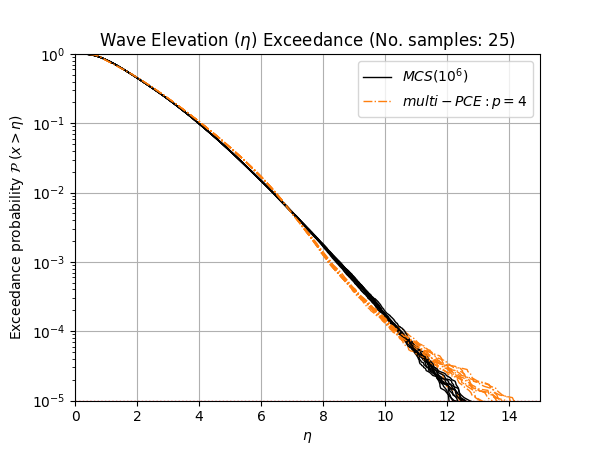

DoE_QuadHem5_mPCE_pred_r0_ecdf_pf5_eta.npy
DoE_QuadHem5_mPCE_pred_r1_ecdf_pf5_eta.npy
DoE_QuadHem5_mPCE_pred_r2_ecdf_pf5_eta.npy
DoE_QuadHem5_mPCE_pred_r3_ecdf_pf5_eta.npy
DoE_QuadHem5_mPCE_pred_r4_ecdf_pf5_eta.npy
DoE_QuadHem5_mPCE_pred_r5_ecdf_pf5_eta.npy
DoE_QuadHem5_mPCE_pred_r6_ecdf_pf5_eta.npy
DoE_QuadHem5_mPCE_pred_r7_ecdf_pf5_eta.npy
DoE_QuadHem5_mPCE_pred_r8_ecdf_pf5_eta.npy
DoE_QuadHem5_mPCE_pred_r9_ecdf_pf5_eta.npy


<IPython.core.display.Javascript object>


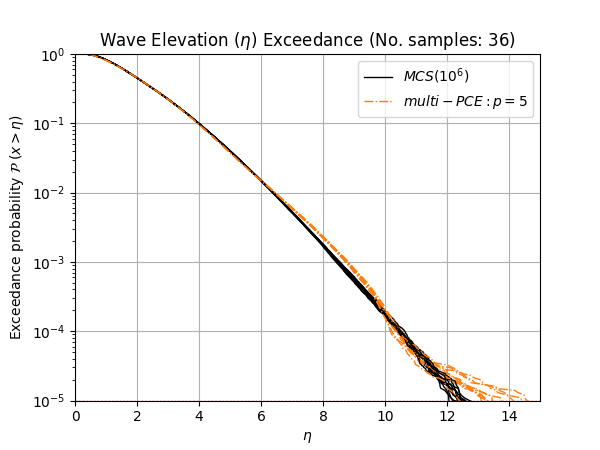

DoE_QuadHem6_mPCE_pred_r0_ecdf_pf5_eta.npy
DoE_QuadHem6_mPCE_pred_r1_ecdf_pf5_eta.npy
DoE_QuadHem6_mPCE_pred_r2_ecdf_pf5_eta.npy
DoE_QuadHem6_mPCE_pred_r3_ecdf_pf5_eta.npy
DoE_QuadHem6_mPCE_pred_r4_ecdf_pf5_eta.npy
DoE_QuadHem6_mPCE_pred_r5_ecdf_pf5_eta.npy
DoE_QuadHem6_mPCE_pred_r6_ecdf_pf5_eta.npy
DoE_QuadHem6_mPCE_pred_r7_ecdf_pf5_eta.npy
DoE_QuadHem6_mPCE_pred_r8_ecdf_pf5_eta.npy
DoE_QuadHem6_mPCE_pred_r9_ecdf_pf5_eta.npy


<IPython.core.display.Javascript object>


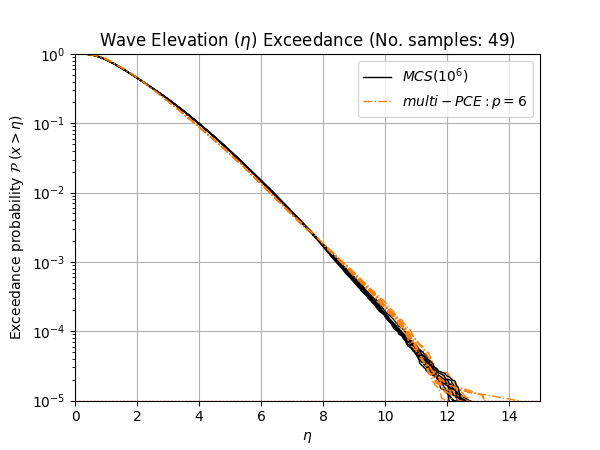

DoE_QuadHem7_mPCE_pred_r0_ecdf_pf5_eta.npy
DoE_QuadHem7_mPCE_pred_r1_ecdf_pf5_eta.npy
DoE_QuadHem7_mPCE_pred_r2_ecdf_pf5_eta.npy
DoE_QuadHem7_mPCE_pred_r3_ecdf_pf5_eta.npy
DoE_QuadHem7_mPCE_pred_r4_ecdf_pf5_eta.npy
DoE_QuadHem7_mPCE_pred_r5_ecdf_pf5_eta.npy
DoE_QuadHem7_mPCE_pred_r6_ecdf_pf5_eta.npy
DoE_QuadHem7_mPCE_pred_r7_ecdf_pf5_eta.npy
DoE_QuadHem7_mPCE_pred_r8_ecdf_pf5_eta.npy
DoE_QuadHem7_mPCE_pred_r9_ecdf_pf5_eta.npy


<IPython.core.display.Javascript object>


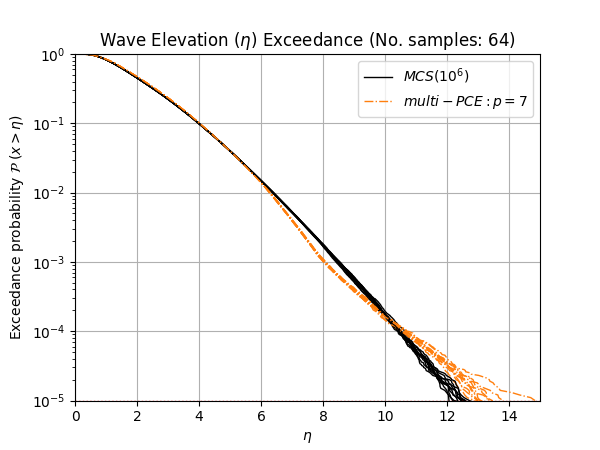

DoE_QuadHem8_mPCE_pred_r0_ecdf_pf5_eta.npy
DoE_QuadHem8_mPCE_pred_r1_ecdf_pf5_eta.npy
DoE_QuadHem8_mPCE_pred_r2_ecdf_pf5_eta.npy
DoE_QuadHem8_mPCE_pred_r3_ecdf_pf5_eta.npy
DoE_QuadHem8_mPCE_pred_r4_ecdf_pf5_eta.npy
DoE_QuadHem8_mPCE_pred_r5_ecdf_pf5_eta.npy
DoE_QuadHem8_mPCE_pred_r6_ecdf_pf5_eta.npy
DoE_QuadHem8_mPCE_pred_r7_ecdf_pf5_eta.npy
DoE_QuadHem8_mPCE_pred_r8_ecdf_pf5_eta.npy
DoE_QuadHem8_mPCE_pred_r9_ecdf_pf5_eta.npy


<IPython.core.display.Javascript object>


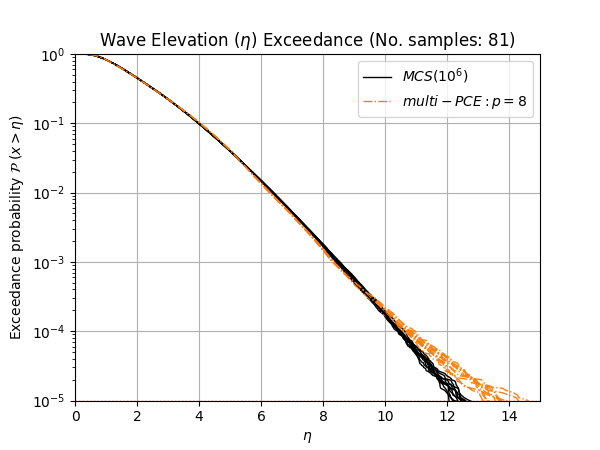

DoE_QuadHem9_mPCE_pred_r0_ecdf_pf5_eta.npy
DoE_QuadHem9_mPCE_pred_r1_ecdf_pf5_eta.npy
DoE_QuadHem9_mPCE_pred_r2_ecdf_pf5_eta.npy
DoE_QuadHem9_mPCE_pred_r3_ecdf_pf5_eta.npy
DoE_QuadHem9_mPCE_pred_r4_ecdf_pf5_eta.npy
DoE_QuadHem9_mPCE_pred_r5_ecdf_pf5_eta.npy
DoE_QuadHem9_mPCE_pred_r6_ecdf_pf5_eta.npy
DoE_QuadHem9_mPCE_pred_r7_ecdf_pf5_eta.npy
DoE_QuadHem9_mPCE_pred_r8_ecdf_pf5_eta.npy
DoE_QuadHem9_mPCE_pred_r9_ecdf_pf5_eta.npy


In [5]:
print(MODEL_DIR_DATA)
pf  = 1e-5
for quad_order in range(5,10):
#     label_added = False
    fig2        = plt.figure(figsize=figsize)
    ax2         = fig2.add_subplot(1,1,1)
    nmcs_repeat           = range(10)
    mcs_exceedance_values = [] 
    pce_exceedance_values = [] 
    gpr_exceedance_values = [] 
    for imcs_repeat in nmcs_repeat:

        mcs_ecdf_filename = 'DoE_McRE6R{:d}_eta_ecdf_pf5.npy'.format(imcs_repeat)
        mcs_ecdf = np.load(os.path.join(MODEL_DIR_DATA, mcs_ecdf_filename)) 
        mpce_mcs_ecdf_filename = 'DoE_QuadHem{:d}_mPCE_pred_r{:d}_ecdf_pf5_eta.npy'.format(quad_order,imcs_repeat)
        print(mpce_mcs_ecdf_filename)
        mpce_mcs_ecdf = np.load(os.path.join(MODEL_DIR_DATA, mpce_mcs_ecdf_filename))
#         pce_mcs_ecdf_mean = np.squeeze(np.mean(np.array(pce_mcs_ecdf), axis=0))
#         gpr_mcs_ecdf_filename = 'DoE_QuadHem{:d}_GPRx_pred_r{:d}_ecdf_pf5_eta.npy'.format(quad_order,imcs_repeat)
#         gpr_mcs_ecdf = np.load(os.path.join(MODEL_DIR_DATA, gpr_mcs_ecdf_filename)) 
        
#         if not label_added:
            # Ture model emperical exceedance plot with mcs results
        label=r'$MCS(10^6)$'
        ax2.semilogy(mcs_ecdf[0,:], 1-mcs_ecdf[1,:],'k',linewidth=1,label=label if imcs_repeat==1 else '')
        # PCE model emperical exceedance plot with mcs results 
        label = r'$multi-PCE: p={:>2d}$'.format(quad_order-1)
        ax2.semilogy(mpce_mcs_ecdf[0,:], 1-mpce_mcs_ecdf[1,:],'-.',color=pltcolors[1],linewidth=1,label=label if imcs_repeat==1 else '')

#             ax2.semilogy(gpr_mcs_ecdf[0,:], 1-gpr_mcs_ecdf[1,:],'-.',
#                          color=pltcolors[2],linewidth=1,label=r'$GPR(RBF+WN)$')
#         else:
#             ax2.semilogy(mcs_ecdf[0,:], 1-mcs_ecdf[1,:],'k')
            
# #             ax2.semilogy(pce_mcs_ecdf_mean[0,:], 1-pce_mcs_ecdf_mean[1,:],'-.',color=pltcolors[11],linewidth=1)  
#             ax2.semilogy(mpce_mcs_ecdf[0,:], 1-mpce_mcs_ecdf[1,:],'-.',color=pltcolors[1],linewidth=1)  
#             ax2.semilogy(gpr_mcs_ecdf[0,:], 1-gpr_mcs_ecdf[1,:],'-.',color=pltcolors[2],linewidth=1)  
            
#         mcs_exceedance_values.append(mcs_ecdf[2,0])
#         pce_exceedance_values.append(pce_mcs_ecdf[2,0])
#         gpr_exceedance_values.append(gpr_mcs_ecdf[2,0])
#         label_added =True

    ax2.set_xlim(0,25)
    ax2.set_ylim(pf/10,1)
    xmin, xmax = ax2.get_xlim()
    ymin, ymax = ax2.get_ylim()
    ax2.plot([xmin,xmax],[pf,pf],':r',linewidth=1)
    ax2.text(xmax,pf,r'pf={:.0e}'.format(pf),horizontalalignment='right',verticalalignment='bottom')    
#     line1 = 1/(1 *365.25*24*3600/1000)
#     line2 = 1/(5 *365.25*24*3600/1000)
#     line3 = 1/(10*365.25*24*3600/1000)
#     ax2.plot([xmin,xmax],[line1,line1],':k',linewidth=1)
#     ax2.text(xmax,line1*1.2,r'1-year',horizontalalignment='right')
#     ax2.plot([xmin,xmax],[line2,line2],':k',linewidth=1)
#     ax2.text(xmax,line2*1.2,r'5-year',horizontalalignment='right')
#     ax2.plot([xmin,xmax],[line3,line3],':k',linewidth=1)
#     ax2.text(xmax,line3*1.2,r'10-year',horizontalalignment='right')
#     ## EC results
#     ax2.plot([ec_extreme_eta[0],ec_extreme_eta[0]],[ymin,line1],'-.k',linewidth=1,label=r'EC')
# #     ax2.text(ec_extreme_eta[0]*0.8,line1*1.2,r'EC(1-year):{:.2f}'.format(ec_extreme_eta[0]),color='red')
    
#     ax2.plot([ec_extreme_eta[1],ec_extreme_eta[1]],[ymin,line2],'-.k',linewidth=1)
# #     ax2.text(ec_extreme_eta[1]*0.8,line2*1.2,r'EC(5-year):{:.2f}'.format(ec_extreme_eta[1]),color='red')
    
#     ax2.plot([ec_extreme_eta[2],ec_extreme_eta[2]],[ymin,line3],'-.k',linewidth=1)
# #     ax2.text(ec_extreme_eta[2]*0.8,line3*1.2,r'EC(10-year):{:.2f}'.format(ec_extreme_eta[2]),color='red')
    
    ax2.set_xlabel(r'$\eta$')
    ax2.set_ylabel(r'Exceedance probability $\mathcal{P}\;(x>\eta)$')
    ax2.set_title(r'Wave Elevation ($\eta$) Exceedance (No. samples: {:d})'.format(quad_order**2))
    plt.legend()
    plt.grid()
    # plt.show()
    plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'ExceedancePlot_mPCE_DoE_Quadrature{:d}_eta-0.pdf'.format(quad_order)))
    ax2.set_xlim(0,15)
    ax2.set_ylim(pf,1)
    plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'ExceedancePlot_mPCE_DoE_Quadrature{:d}_eta-1.pdf'.format(quad_order)))






# 3. Monte Carlo

In [85]:
filename = 'DoE_McRE7R0.npy'
data_set = np.load(os.path.join(MODEL_DIR_DATA,filename))


FileNotFoundError: [Errno 2] No such file or directory: '/Users/jinsongliu/External/MUSE_UQ_DATA/linear_oscillator/Data/DoE_McRE7R0.npy'

In [20]:
print(data_set.shape)
samples_zeta = data_set[:2,:]
samples_x = data_set[2:,:]


(4, 10000000)


<IPython.core.display.Javascript object>


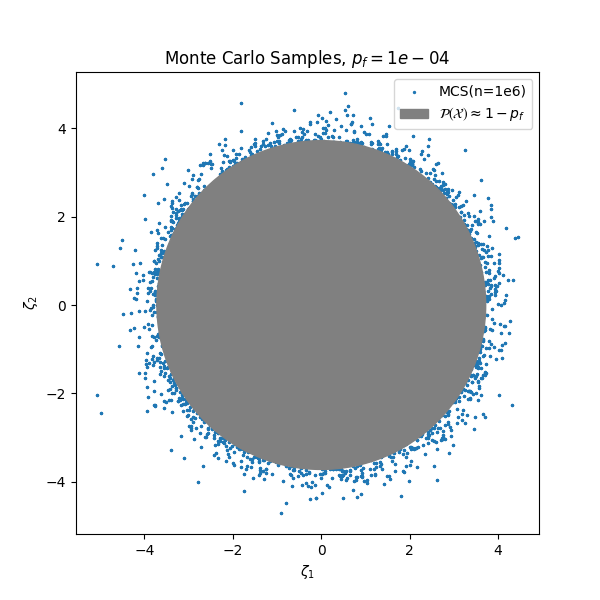

In [26]:
EC = make_circle(beta)
zeta_fig, zeta_ax = plt.subplots(figsize=(6,6))
plt_zeta_samples  = zeta_ax.scatter(x=samples_zeta[0,:1000000],y=samples_zeta[1,:1000000],s=2,zorder=0);
plt_circle        = plt.Circle((0, 0), beta, color='gray', zorder=10);
# plt_EC,           = zeta_ax.plot(EC[:,0],EC[:,1],'o',label=r'EC',color=pltcolors[1])

zeta_ax.add_artist(plt_zeta_samples)
zeta_ax.add_artist(plt_circle)
# zeta_ax.add_artist(plt_EC)

zeta_ax.set_xlabel(r'$\zeta_1$')
zeta_ax.set_ylabel(r'$\zeta_2$')
zeta_ax.set_title(r'Monte Carlo Samples, $p_f = {:.0e}$'.format(prob_fails))
zeta_ax.set_aspect('equal', 'box')
# zeta_ax.set_xlim(-np.floor(beta),np.floor(beta))
# zeta_ax.set_ylim(-np.floor(beta),np.floor(beta))
zeta_ax.legend([plt_zeta_samples,plt_circle],
               [r'MCS(n=1e6)', r'$\mathcal{P(X)}\approx 1-p_f$'],loc=1)
plt.savefig(os.path.join(MODEL_DIR_FIGURE, 'samples_zeta_joint.png'))

<IPython.core.display.Javascript object>


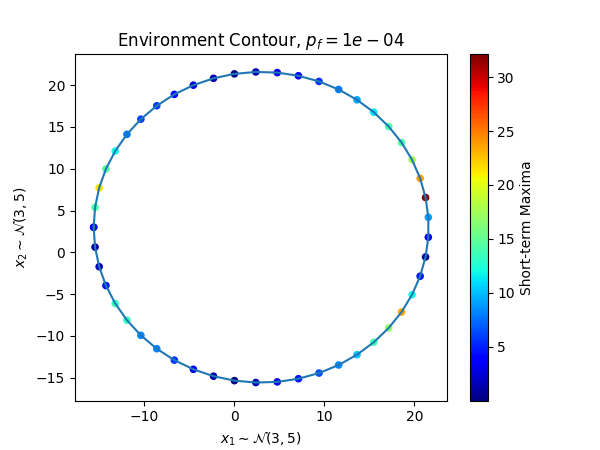

[4.40914275e+00 8.64405016e-01 1.66557676e+00 4.76604949e+00
 1.35599438e+01 1.32019447e+01 8.39015093e+00 8.19793745e+00
 5.72448988e+00 3.54283887e+00 1.28546564e+00 2.01323997e-02
 1.64637124e+00 3.25583473e+00 4.56031625e+00 6.42902271e+00
 8.36986025e+00 1.02484779e+01 1.37013782e+01 1.68604839e+01
 2.35976969e+01 1.19602118e+01 4.78424109e+00 7.76509308e-01
 3.43116680e+00 9.14420453e+00 3.21416861e+01 2.37727569e+01
 1.74101048e+01 1.43688129e+01 1.42518753e+01 1.11932094e+01
 9.38475176e+00 7.79968209e+00 5.65063069e+00 3.82681079e+00
 3.25258729e+00 1.63227750e+00 1.76441532e-02 1.52178092e+00
 2.59858948e+00 4.37818643e+00 6.10732982e+00 6.25706744e+00
 7.88222404e+00 1.20312139e+01 1.46590394e+01 2.15196150e+01
 1.42867619e+01 4.17107278e+00]


In [89]:
y_stats = np.load('test_linear_oscillator_EC_y_stats.npy')
y_st_max = np.squeeze(y_stats[:,4,2])

# fig_ec, axs_ec= plt.subplots(1,1,figsize=(4*1.5,3*1.5))
plt.figure(figsize=figsize)
plt.plot(EC_x[:,0],EC_x[:,1],'-')
plt.xlabel('$x_1\sim \mathcal{N}(3,5)$')
plt.ylabel('$x_2\sim \mathcal{N}(3,5)$')
plt.title('Environment Contour, $p_f={:.0e}$'.format(prob_fails));

plt.scatter(EC_x[:,0],EC_x[:,1], c=y_st_max, s=20,cmap=cm.jet)
# plt.aspect('equal', 'box')
corbar = plt.colorbar()    
corbar.set_label(r'Short-term Maxima')
print(y_st_max)

In [95]:
y_excd = np.squeeze(np.load('test_linear_oscillator_excd.npy'))
print(y_excd.shape)
# y_st_max = np.squeeze(y_stats[:,4,2])

# # fig_ec, axs_ec= plt.subplots(1,1,figsize=(4*1.5,3*1.5))
# plt.figure(figsize=figsize)
# plt.plot(EC_x[:,0],EC_x[:,1],'-')
# plt.xlabel('$x_1\sim \mathcal{N}(3,5)$')
# plt.ylabel('$x_2\sim \mathcal{N}(3,5)$')
# plt.title('Environment Contour, $p_f={:.0e}$'.format(prob_fails));

# plt.scatter(EC_x[:,0],EC_x[:,1], c=y_st_max, s=20,cmap=cm.jet)
# # plt.aspect('equal', 'box')
# corbar = plt.colorbar()    
# corbar.set_label(r'Short-term Maxima')
# print(y_st_max)

(3, 506)


In [ ]:
plt.savefig(os.path.join(MODEL_DIR_FIGURE, 'samples_zeta_joint.pdf'))

In [ ]:
zeta_plot = sns.jointplot(x=samples_zeta[0,:],y=samples_zeta[1,:], scatter_kws={"s": 5});
zeta_plot.savefig(os.path.join(MODEL_DIR_FIGURE, 'samples_zeta_joint.pdf'))

In [ ]:
zeta_plot.savefig(os.path.join(MODEL_DIR_FIGURE, 'samples_zeta_joint.pdf'), quality=50)